# Solving the Perfect Phylogeny Mixture problem and variants using ILP

## Single solution

In [1]:
import numpy as np
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
F = np.array([[0.8, 0.8, 0.8, 0., 0., 0.], [0.7, 0.6, 0., 0.6, 0.0, 0.0], [0.8, 0., 0., 0., 0.6, 0.4]])

In [3]:
def createG(F):
    """
    Create the ancestry graph given frequencies F

    Parameters:
        F (np.array): Frequency matrix F

    Returns:
        nx.DiGraph: Ancestry graph
    """
    G = nx.DiGraph()
    G.add_nodes_from(list(range(F.shape[1])))

    for i in range(F.shape[1]):
        for j in range(F.shape[1]):
            anc_ij = True
            if i == j:
                continue
            for p in range(F.shape[0]):
                anc_ij = anc_ij and (F[p,i] >= F[p,j])
            if anc_ij:
                G.add_edge(i, j)

    return G

In [4]:
G = createG(F)

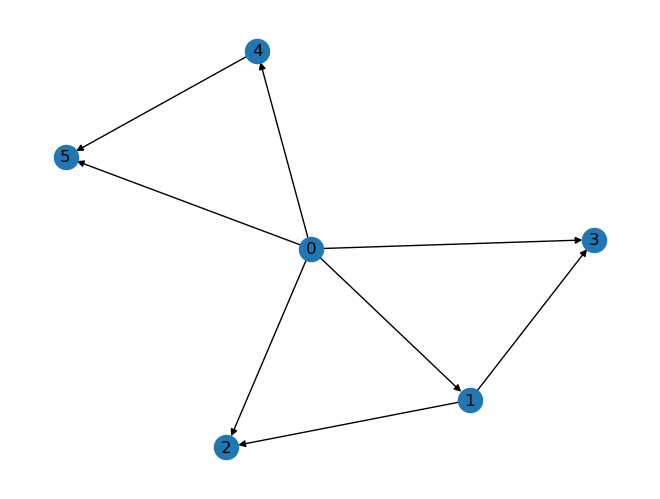

In [5]:
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw(G, pos, with_labels=True)

We have the following ILP for the PPM problem given frequency matrix $F$ and corresponding ancestry graph $G$.
$$
\begin{align}
\max \quad & \sum_{(i,j) \in E(G)} x_{i,j}\\
\mathrm{s.t.}\quad & \sum_{i=1}^n r_i = 1\\
& r_j + \sum_{(i,j)\in E(G)} x_{i,j} = 1 & \forall j \in [n]\\
& \sum_{(i,j) \in E(G)} f_{p,j} \cdot x_{i,j} \le f_{p,i} & \forall p \in [m], i \in [n]\\
& r_i \in \{0,1\} & \forall i \in [n]\\
& x_{i,j} \in \{0,1\} & \forall (i,j) \in E(G)
\end{align}
$$

where each variable $r_i \in \{0,1\}$ indicates that the node corresponding to mutation $i \in [n]$ is the root and each variable $x_{i,j} \in \{0,1\}$ indicates the inclusion of the edge $(i,j) \in E(G)$ into the solution tree $T$.

In [6]:
def createILP(F, G):
    """
    Create the ILP model given frequencies F and ancestry graph G

    Parameters:
        F (np.array): Frequency matrix F
        G (nx.DiGraph): Ancestry graph

    Returns:
        gurobipy.Model: Gurobi ILP model
    """
    model = gb.Model("ppm")
    m = F.shape[0]
    n = F.shape[1]
    nrEdges = len(G.edges)

    # Initialize variables
    x = model.addVars(range(nrEdges), vtype=gb.GRB.BINARY)
    r = model.addVars(range(n), vtype=gb.GRB.BINARY)

    edgeToIdx = {}
    for edgeIdx, (i,j) in enumerate(G.edges):
        edgeToIdx[(i,j)] = edgeIdx
        x[edgeIdx].varName = "x_" + str(i) + "_" + str(j)


    for node in range(n):
        r[node].varName = "r_" + str(node)

    # Unique root constraint
    model.addConstr(gb.quicksum(r[i] for i in range(n)) == 1)

    for node in range(n):
        model.addConstr(r[node] + gb.quicksum(x[edgeToIdx[parent]] for parent in G.in_edges(node)) == 1)

        for p in range(m):
            model.addConstr(gb.quicksum(F[p,j] * x[edgeToIdx[(i,j)]] for (i,j) in G.out_edges(node)) <= F[p, node])
    
    model.setObjective(gb.quicksum(x[ij] for ij in range(nrEdges)), gb.GRB.MAXIMIZE)
    
    model.update()
    return model

In [7]:
model = createILP(F, G)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-01


In [8]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 25 rows, 14 columns and 29 nonzeros
Model fingerprint: 0x7be6dab1
Variable types: 0 continuous, 14 integer (14 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 25 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%


In [9]:
def extractSolution(model, verbose=False):
    """
    Extract solution tree from solved model

    Parameters:
        model (gurobipy.Model): Gurobi ILP model
        verbose (bool): Printing of variables to stdout

    Returns:
        gurobipy.Model: Gurobi ILP model
    """
    T = []
    for idx, v in enumerate(model.getVars()):
        if v.Xn > 0.5:
            if verbose:
                print(v.varName, v.Xn)
            if v.varName.startswith("x"):
                T.append(list(G.edges)[idx])
    return T

In [10]:
T = extractSolution(model)

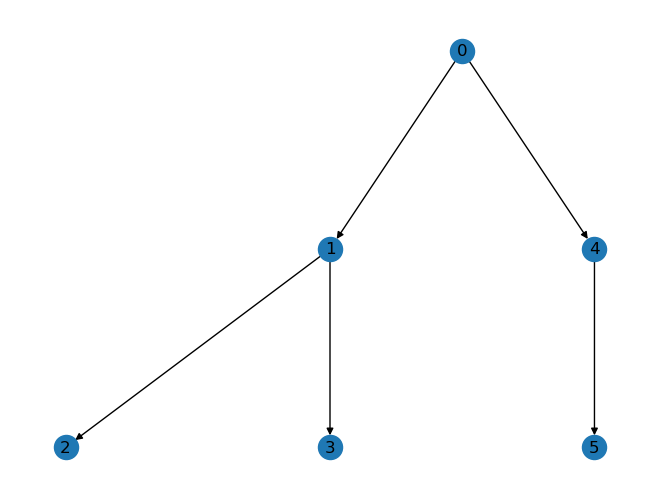

In [11]:
pos = nx.nx_agraph.graphviz_layout(G.edge_subgraph(T), prog="dot")
nx.draw(G.edge_subgraph(T), pos, with_labels=True)

## Enumerating the solution space

Gurobi can be used to enumerate the solution space as we show in the following.

In [12]:
F = np.array([[1., 0., 0., 0.06, 0], [1, 0.75, 0.33, 0., 0.25]])

In [13]:
G = createG(F)

In [14]:
model = createILP(F, G)

In [15]:
model.setParam(gb.GRB.Param.PoolSolutions, 1024)  # number of solutions to find (upper bound)
model.setParam(gb.GRB.Param.PoolSearchMode, 2) # with a setting of 2, the solver will find the n best solutions.

Set parameter PoolSolutions to value 1024
Set parameter PoolSearchMode to value 2


In [16]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 16 rows, 12 columns and 24 nonzeros
Model fingerprint: 0xc2d18ab6
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Variable types: 0 continuous, 3 integer (3 binary)

Root relaxation: objective 4.000000e+00, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0         4.00000    4.00000  0.00%     -    0s

Optimal soluti

In [17]:
solT = []
for e in range(model.solCount):
    model.setParam(gb.GRB.Param.SolutionNumber, e)
    T = extractSolution(model)
    solT.append(T)

In [18]:
solT

[[(0, 1), (0, 3), (0, 4), (1, 2)],
 [(0, 1), (0, 3), (1, 2), (2, 4)],
 [(0, 1), (0, 3), (1, 2), (1, 4)]]

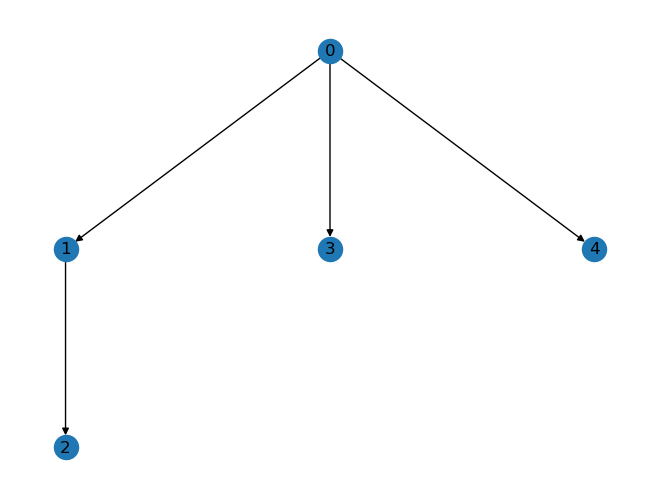

In [19]:
pos = nx.nx_agraph.graphviz_layout(G.edge_subgraph(solT[0]), prog="dot")
nx.draw(G.edge_subgraph(solT[0]), pos, with_labels=True)

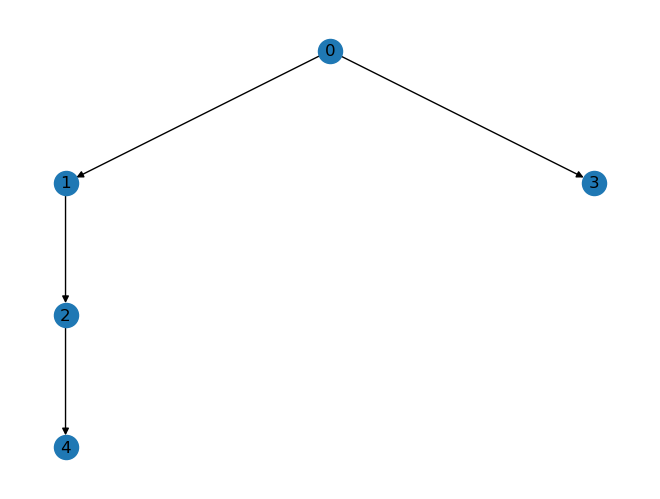

In [20]:
pos = nx.nx_agraph.graphviz_layout(G.edge_subgraph(solT[1]), prog="dot")
nx.draw(G.edge_subgraph(solT[1]), pos, with_labels=True)

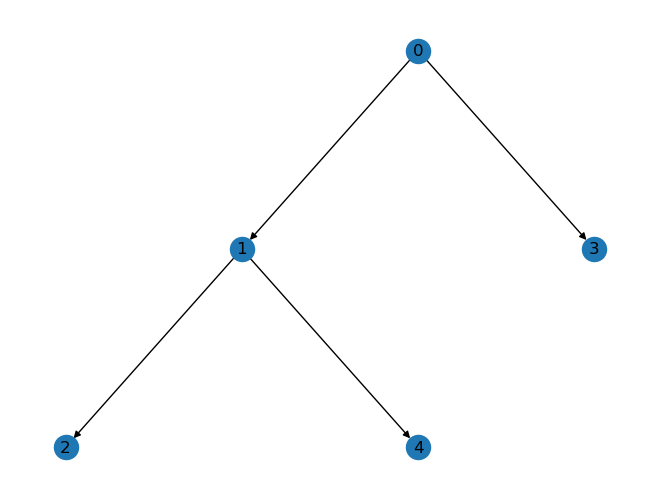

In [21]:
pos = nx.nx_agraph.graphviz_layout(G.edge_subgraph(solT[2]), prog="dot")
nx.draw(G.edge_subgraph(solT[2]), pos, with_labels=True)

## Maximum Likelihood Variant for a Fixed Tree

We now explore a maximum likelihood variant of the PPM problem. Rather than given a frequency matrix $F \in [0,1]^{m \times n}$ we are given two read count matrices $A, D \in \mathbb{N}^{m \times n}$ where matrix $A = [a_{p,i}]$ indicates the number of variant reads and matrix $D = [d_{p,i}]$ indicates the number of total reads. The question now becomes can we find a frequency matrix $F$ that admits a phylogeny $T$ with maximum likelihood. Specifically, we model variant reads as a binomial distribution, parameterized by the total number $d_{p,i}$ of reads the frequency $f_{p,i}$, i.e. $a_{p,i} \sim \mathrm{binom}(d_{p,i}, f_{p,i})$. Using independence across samples and mutations, we have the following likelihood:

$$\Pr(A \mid D, F) = \prod_{p=1}^m \prod_{i=1}^n \mathrm{binom}(a_{p,i} \mid d_{p,i}, f_{p,i}) = \prod_{p=1}^m \prod_{i=1}^n \binom{d_{p,i}}{a_{p,i}} (f_{p,i})^{a_{p,i}} (1-f_{p,i})^{d_{p,i}-a_{p,i}}.$$

To determine a maximum likelihood frequency matrix $F$ that is a solution to a given phylogeny $T$, we have the following optimization problem.

$$
\begin{align}
\max \quad & \prod_{p=1}^m \prod_{i=1}^n \binom{d_{p,i}}{a_{p,i}} (f_{p,i})^{a_{p,i}} (1-f_{p,i})^{d_{p,i}-a_{p,i}}\\
\mathrm{s.t.}\quad & f_{p,i} \ge \sum_{(i,j) \in E(T)} f_{p,j} & \forall p \in [m], i \in [n]\\
& f_{p,i} \in [0,1] & \forall p \in [m], i \in [n]
\end{align}
$$

Taking the logarithm of the objective function and omitting the constant $\binom{d_{p,i}}{a_{p,i}}$ leads to the following problem.

$$
\begin{align}
\max \quad & \sum_{p=1}^m \sum_{i=1}^n \left[ a_{p,i} \log(f_{p,i}) + (d_{p,i}-a_{p,i})\log(1-f_{p,i}) \right]\\
\mathrm{s.t.}\quad & f_{p,i} \ge \sum_{(i,j) \in E(T)} f_{p,j} & \forall p \in [m], i \in [n]\\
& f_{p,i} \in [0,1] & \forall p \in [m], i \in [n]
\end{align}
$$

Clearly, the objective function is still not linear. We will use the $\lambda$ method [(Lee & Wilson, 2001)](https://doi.org/10.1016/S0166-218X(00)00216-X) to obtain a piecewise linear approximation. We begin by defining the function $$g(f, a, d) = a_{p,i} \log(f_{p,i}) + (d_{p,i}-a_{p,i})\log(1-f_{p,i}).$$

Here's a plot of this function with $a=5$ and $d=10$. You can see the maximum likelihood value is attained for $f = a/d = 0.5$.

In [22]:
def function_g(f, a, d):
    """
    Binomial log-likelihood function (omitting binomial coefficient term)

    Parameters:
        f (float): Binomial proportion
        a (int): Number of successes
        d (int): Number of trials

    Returns:
        float: Log-likelihood
    """
    return a * np.log(f) + (d-a)*np.log(1-f)

In [23]:
def plot_g(a, d, L, eps=0.00001):
    """
    Plots piece-wise linear approximation of binomial log-likelihood function

    Parameters:
        a (int): Number of successes
        d (int): Number of trials
        L (int): Number of breakpoints
        eps (float): Epsilon

    Returns:
        None
    """
    x_values = np.linspace(eps, 1-eps, 100)
    x_values2 = np.linspace(eps, 1-eps, L)
    y_values = function_g(x_values, a, d)
    y_values2 = function_g(x_values2, a, d)

    # Plot the function
    plt.plot(x_values, y_values, label='g(f,a,d)')
    plt.plot(x_values2, y_values2, label='PWLA')
    plt.xlabel('f')

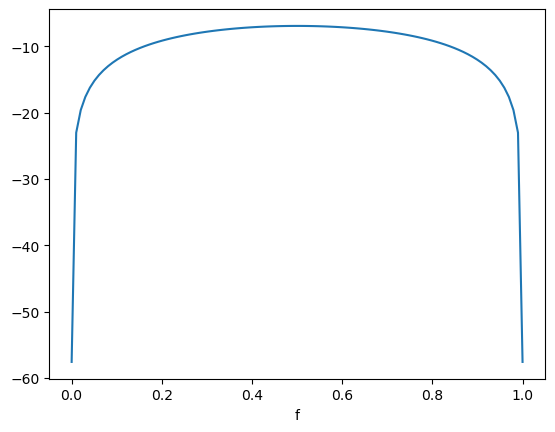

In [24]:
plot_g(5, 10, 0)

To approximate $g$, we will pre-compute at $L$ values $x_1,\ldots,x_L$. For example, with $L=5$ and setting $x_\ell = \ell/5$ (we actually have to use $x_\ell = \min\{1-\epsilon,\max\{\epsilon,\ell/5\}\}$ to avoid evaluating $\log(0)=-\infty$), we get the following piecewise linear approximation of $g(\cdot,5,10)$, shown in orange.

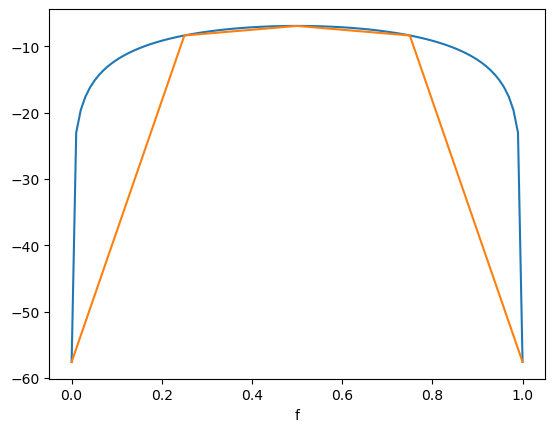

In [45]:
plot_g(5, 10, 5)

We will introduce variables $\lambda_{\ell,p,i} \in [0,1]$ for each coordinate $\ell \in [L]$, sample $p \in [m]$ and mutation $i \in [n]$. In addition, we introduce constraints 
$$
\begin{align}
\sum_{\ell=1}^L \lambda_{\ell,p,i} x_\ell & = f_{p,i}\\
\sum_{\ell=1}^L \lambda_{\ell,p,i} & = 1
\end{align}
$$ 
such that each $f_{p,i}$ equals a convex combination of the fixed coordinates $x_1,\ldots,x_L$. Now we can approximate $g(f_{p,i},a_{p,i},d_{p,i})$ by $$\sum_{\ell=1}^L \lambda_{\ell,p,i} \cdot g(x_\ell, a_{p,i}, d_{p,i}).$$

Putting everything together, we get the following linear program.

$$
\begin{align}
\max \quad & \sum_{p=1}^m \sum_{i=1}^n \sum_{\ell=1}^L \lambda_{\ell,p,i} \cdot g(x_\ell, a_{p,i}, d_{p,i})\\
\mathrm{s.t.}\quad & f_{p,i} \ge \sum_{(i,j) \in E(T)} f_{p,j} & \forall p \in [m], i \in [n]\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} x_\ell = f_{p,i}  & \forall p \in [m], i \in [n]\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} = 1  & \forall p \in [m], i \in [n]\\
& f_{p,i} \in [0,1] & \forall p \in [m], i \in [n]\\
& \lambda_{\ell,p,i} \in [0,1] & \forall \ell \in [L], p \in [m], i \in [n]
\end{align}
$$
Let's implement this!

In [26]:
def createILP_MLE(A, D, T, L, eps=0.00001):
    """
    Create the ILP 

    Parameters:
        A (np.array): Variant read count matrix
        D (np.array): Total read count matrix
        T (nx.DiGraph): Tree
        L (int): Number of segments
        eps (float): Epsilon

    Returns:
        gb.Model: ILP model
    """
    model = gb.Model("ppm-mle")

    m = A.shape[0]
    n = A.shape[1]
    
    assert(A.shape == D.shape)
    assert(len(T) == n)
    
    f = model.addVars(range(m*n), vtype=gb.GRB.CONTINUOUS, lb=0, ub=1)
    for p in range(m):
        for i in range(n):
            f[p*n + i].varName = "f_" + str(p) + "_" + str(i)
    
    lmda = model.addVars(range(m*n*L), vtype=gb.GRB.CONTINUOUS, lb=0, ub=1)
    for p in range(m):
        for i in range(n):
            for l in range(L):
                lmda[p*n*L + i*L + l].varName = "lambda_" + str(p) + "_" + str(i) + "_" + str(l)

    x_values = np.linspace(eps, 1-eps, L)

    for p in range(m):
        for i in range(n):
            model.addConstr(gb.quicksum(f[p*n+j] for (i,j) in T.out_edges(i)) <= f[p*n + i])
            model.addConstr(gb.quicksum(x_values[l] * lmda[p*n*L + i*L + l] for l in range(L)) == f[p*n + i])
            model.addConstr(gb.quicksum(lmda[p*n*L + i*L + l] for l in range(L)) == 1)
            
    
    model.setObjective(gb.quicksum(lmda[p*n*L + i*L + l] * function_g(x_values[l], A[p,i], D[p,i])
                                   for p in range(m) for i in range(n) for l in range(L)), gb.GRB.MAXIMIZE)
    
    model.update()
    return model

In [27]:
A = np.array([[4, 4, 4, 0, 0, 0], [7, 6, 0, 3, 0, 0], [8, 0, 0, 0, 3, 2]])
D = np.array([[5, 5, 5, 10, 10, 5], [10, 10, 5, 5, 5, 5], [10, 5, 5, 2, 5, 5]])

In [28]:
edges_T = [(0, 1), (0, 4), (1, 2), (1, 3), (4, 5)]

In [29]:
T = nx.DiGraph(edges_T)

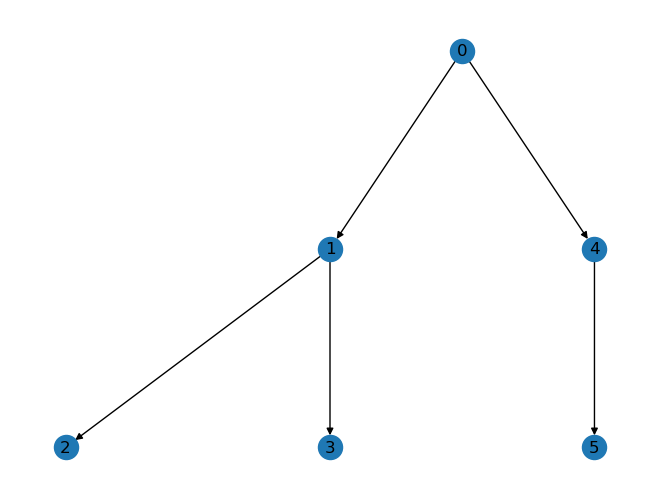

In [30]:
pos = nx.nx_agraph.graphviz_layout(T, prog="dot")
nx.draw(T, pos, with_labels=True)

In [31]:
model = createILP_MLE(A, D, T, 50)

In [32]:
#model = createILP_MLE(np.array([[1, 1, 2, 3, 4, 5]]), np.array([[10,10,10,10,10,10]]), nx.DiGraph([(5,4),(4,3),(3,2),(2,1),(1,0)]), 2)

In [33]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 54 rows, 918 columns and 1851 nonzeros
Model fingerprint: 0x4c94ba43
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [2e-05, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 18 rows and 9 columns
Presolve time: 0.00s
Presolved: 36 rows, 909 columns, 1824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5450151e+01   6.061283e+00   0.000000e+00      0s
      13   -3.5450209e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.00 seconds (0.00 work units)
Optimal objective -3.545020882e+01


In [34]:
def extractSolution(model, m, n, eps=0.00001, verbose=False):
    """
    Extract solution tree from solved model

    Parameters:
        model (gurobipy.Model): Gurobi ILP model
        m (int): Number of samples
        n (int): Number of mutations
        verbose (bool): Printing of variables to stdout
        eps (float): Epsilon

    Returns:
        gurobipy.Model: Gurobi ILP model
    """
    F = np.zeros((m, n))
    for idx, v in enumerate(model.getVars()):
        if v.varName.startswith("f"):
            s = v.varName.split("_")
            p = int(s[1])
            i = int(s[2])
            if v.x > eps:
                F[p,i] = v.x

        if verbose and (v.varName.startswith("f") or v.x > 0):
            print(v.varName, v.x)
            
    return F

In [35]:
extractSolution(model, 3, 6)

array([[7.95932449e-01, 7.95922449e-01, 7.95912449e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [6.93873673e-01, 5.91844898e-01, 0.00000000e+00, 5.91834898e-01,
        0.00000000e+00, 0.00000000e+00],
       [7.95912449e-01, 2.00000000e-05, 0.00000000e+00, 0.00000000e+00,
        5.91834898e-01, 4.08165102e-01]])

Note that concavity of the function $g$ together with the optimization direction (maximization) guarantees that at most two lambdas will be picked; and if two lambdas are picked, they will be adjacent.

## Maximum Likelihood Variant for an Unknown Tree

$$
\begin{align}
\max \quad & \sum_{p=1}^m \sum_{i=1}^n \sum_{\ell=1}^L \lambda_{\ell,p,i} \cdot g(x_\ell, a_{p,i}, d_{p,i})\\
\mathrm{s.t.}\quad & \sum_{i=1}^n r_i = 1\\
& r_j + \sum_{i \ne j} x_{i,j} = 1 & \forall j \in [n]\\
& \sum_{j \ne i} f_{p,j} \cdot x_{i,j} \le f_{p,i} & \forall p \in [m], i \in [n]\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} x_\ell = f_{p,i}  & \forall p \in [m], i \in [n]\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} = 1  & \forall p \in [m], i \in [n]\\
& r_i \in \{0,1\} & \forall i \in [n]\\
& x_{i,j} \in \{0,1\} & \forall i,j \in [n], i \ne j\\
& f_{p,i} \in [0,1] & \forall p \in [m], i \in [n]\\
& \lambda_{\ell,p,i} \in [0,1] & \forall \ell \in [L], p \in [m], i \in [n]
\end{align}
$$

Linearization such that $\bar{f}_{i,p,j} := f_{p,j} \cdot x_{i,j}$ yields

$$
\begin{align}
\max \quad & \sum_{p=1}^m \sum_{i=1}^n \sum_{\ell=1}^L \lambda_{\ell,p,i} \cdot g(x_\ell, a_{p,i}, d_{p,i})\\
\mathrm{s.t.}\quad & \sum_{i=1}^n r_i = 1\\
& r_j + \sum_{i \ne j} x_{i,j} = 1 & \forall j \in [n]\\
& \sum_{j \ne i} \bar{f}_{i,p,j} \le f_{p,i} & \forall p \in [m], i \in [n]\\
& \bar{f}_{i,p,j} \le f_{p,j} & \forall p \in [m], i,j \in [n], i \ne j\\
& \bar{f}_{i,p,j} \le x_{i,j} & \forall p \in [m], i,j \in [n], i \ne j\\
& \bar{f}_{i,p,j} \ge f_{p,j} + x_{i,j} - 1 & \forall p \in [m], i,j \in [n], i \ne j\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} x_\ell = f_{p,i}  & \forall p \in [m], i \in [n]\\
& \sum_{\ell=1}^L \lambda_{\ell,p,i} = 1  & \forall p \in [m], i \in [n]\\
& r_i \in \{0,1\} & \forall i \in [n]\\
& x_{i,j} \in \{0,1\} & \forall i,j \in [n], i \ne j\\
& \bar{f}_{i,p,j} \in [0,1] & \forall p \in [m], i,j \in [n], i \ne j\\
& f_{p,i} \in [0,1] & \forall p \in [m], i \in [n]\\
& \lambda_{\ell,p,i} \in [0,1] & \forall \ell \in [L], p \in [m], i \in [n]
\end{align}
$$


In [36]:
def createILP_PPM_MLE(A, D, L):
    """
    Create the ILP 

    Parameters:
        A (np.array): Variant read count matrix
        D (np.array): Total read count matrix
        L (int): Number of segments

    Returns:
        gb.Model: ILP model
    """
    model = gb.Model("ppm-mle")

    m = A.shape[0]
    n = A.shape[1]
    
    assert(A.shape == D.shape)

    x = model.addVars(range(n*n - n), vtype=gb.GRB.BINARY)
    r = model.addVars(range(n), vtype=gb.GRB.BINARY)

    edgeToIdx = {}
    idxToEdge = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            idx = len(idxToEdge)
            edgeToIdx[(i,j)] = idx
            idxToEdge.append((i,j))
            # print(idx,(i,j),edgeToIdx[(i,j)],idxToEdge[idx])
            x[idx].varName = "x_" + str(i) + "_" + str(j)

    for i in range(n):
        r[i].varName = "r_" + str(i)

    bar_f = model.addVars(range(n*m*n), vtype=gb.GRB.CONTINUOUS, lb=0, ub=1)
    for i in range(n):
        for p in range(m):
            for j in range(n):
                bar_f[i * m * n + p*n + j].varName = "bar_f_" + str(i) + "_" + str(p) + "_" + str(j)

    f = model.addVars(range(m*n), vtype=gb.GRB.CONTINUOUS, lb=0, ub=1)
    for p in range(m):
        for i in range(n):
            f[p*n + i].varName = "f_" + str(p) + "_" + str(i)
    
    lmda = model.addVars(range(m*n*L), vtype=gb.GRB.CONTINUOUS, lb=0, ub=1)
    for p in range(m):
        for i in range(n):
            for l in range(L):
                lmda[p*n*L + i*L + l].varName = "lambda_" + str(p) + "_" + str(i) + "_" + str(l)

    # unique root
    model.addConstr(gb.quicksum(r[i] for i in range(n)) == 1)

    for i in range(n):
        model.addConstr(r[i] + gb.quicksum(x[edgeToIdx[(j,i)]] if i != j else 0 for j in range(n)) == 1)
        for p in range(m):
            model.addConstr(gb.quicksum(bar_f[i * m * n + p*n + j] if i != j else 0 for j in range(n)) <= f[p*n + i])
            for j in range(n):
                if i == j:
                    continue
                model.addConstr(bar_f[i * m * n + p*n + j] <= x[edgeToIdx[(i,j)]])
                model.addConstr(bar_f[i * m * n + p*n + j] <= f[p*n + j])
                model.addConstr(bar_f[i * m * n + p*n + j] >= x[edgeToIdx[(i,j)]] + f[p*n + j] - 1)
    
    eps = 0.00001
    x_values = np.linspace(eps, 1-eps, L)

    for p in range(m):
        for i in range(n):
            model.addConstr(gb.quicksum(x_values[l] * lmda[p*n*L + i*L + l] for l in range(L)) == f[p*n + i])
            model.addConstr(gb.quicksum(lmda[p*n*L + i*L + l] for l in range(L)) == 1)
    
    model.setObjective(gb.quicksum(lmda[p*n*L + i*L + l] * function_g(x_values[l], A[p,i], D[p,i])
                                   for p in range(m) for i in range(n) for l in range(L)), gb.GRB.MAXIMIZE)
    
    model.update()
    return model

In [37]:
model = createILP_PPM_MLE(A, D, 50)

In [38]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 331 rows, 1062 columns and 2598 nonzeros
Model fingerprint: 0x26b85855
Variable types: 1026 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [2e-05, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 18 columns
Presolve time: 0.00s
Presolved: 331 rows, 1044 columns, 2598 nonzeros
Variable types: 1008 continuous, 36 integer (36 binary)
Found heuristic solution: objective -71.6243187
Found heuristic solution: objective -39.8088464

Root relaxation: objective -3.545015e+01, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -35

In [39]:
for idx, v in enumerate(model.getVars()):
    if v.x > 0 or v.varName.startswith("f"):
        print(v.varName, v.x)

x_0_1 1.0
x_0_4 1.0
x_1_2 1.0
x_1_3 1.0
x_4_5 1.0
r_0 1.0
bar_f_0_0_1 0.7959224489795919
bar_f_0_0_4 9.99999999995449e-06
bar_f_0_1_1 0.5918448979591837
bar_f_0_1_4 9.99999999995449e-06
bar_f_0_2_1 1.999999999990898e-05
bar_f_0_2_4 0.5918348979591838
bar_f_1_0_2 0.7959124489795919
bar_f_1_0_3 9.99999999995449e-06
bar_f_1_1_2 9.99999999995449e-06
bar_f_1_1_3 0.5918348979591838
bar_f_1_2_2 9.99999999995449e-06
bar_f_1_2_3 9.99999999995449e-06
bar_f_4_0_5 1e-05
bar_f_4_1_5 1e-05
bar_f_4_2_5 0.4081651020408164
f_0_0 0.7959324489795918
f_0_1 0.7959224489795919
f_0_2 0.7959124489795919
f_0_3 1e-05
f_0_4 1e-05
f_0_5 1e-05
f_1_0 0.6938736734693879
f_1_1 0.5918448979591837
f_1_2 1e-05
f_1_3 0.5918348979591838
f_1_4 1e-05
f_1_5 1e-05
f_2_0 0.7959124489795919
f_2_1 1.999999999990898e-05
f_2_2 1e-05
f_2_3 1e-05
f_2_4 0.5918348979591838
f_2_5 0.4081651020408164
lambda_0_0_39 0.9990199803996125
lambda_0_0_40 0.0009800196003875161
lambda_0_1_39 0.9995099901998062
lambda_0_1_40 0.0004900098001937581
l

In [40]:
A[1:2,], D[1:2]

(array([[7, 6, 0, 3, 0, 0]]), array([[10, 10,  5,  5,  5,  5]]))

In [41]:
model2 = createILP_MLE(A[1:2,], D[1:2,], nx.DiGraph([(0,1), (0,2), (0,5), (1,3), (1,4)]), 50)
model2.optimize()
for idx, v in enumerate(model2.getVars()):
    if v.x > 0 or v.varName.startswith("f"):
        print(v.varName, v.x)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 18 rows, 306 columns and 617 nonzeros
Model fingerprint: 0x8755c73c
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [5e-05, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 14 rows, 306 columns, 613 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6206929e+01   1.877573e+00   0.000000e+00      0s
       7   -1.6206930e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.620692998e+01
f_0_0 0.6938736734693879
f_0_1 0.5918448979591837
f_0_2 1e-05
f_0_3 0.5918348979591838
f_0_4 1e-05
f_0_5 1e-05
lambda_0_0_34 1.0
lambda_0_1_29 0.9995099901998062
lambda_0_1_30 0.00049000

In [42]:
A[1:2,] / D[1:2,]

array([[0.7, 0.6, 0. , 0.6, 0. , 0. ]])